In [20]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from reckit import Configurator
from importlib.util import find_spec
from importlib import import_module
from reckit import typeassert
import os
import numpy as np
import random

import pprint
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)


In [21]:

def _set_random_seed(seed=2020):
    np.random.seed(seed)
    random.seed(seed)

    try:
        import tensorflow as tf
        tf.set_random_seed(seed)
        print("set tensorflow seed")
    except:
        pass
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        print("set pytorch seed")
    except:
        pass

In [22]:

@typeassert(recommender=str, platform=str)
def find_recommender(recommender, platform="pytorch"):
    model_dirs = set(os.listdir("model"))
    model_dirs.remove("base")

    module = None
    if platform == "pytorch":
        platforms = ["pytorch", "tensorflow"]
    elif platform == "tensorflow":
        platforms = ["tensorflow", "pytorch"]
    else:
        raise ValueError(f"unrecognized platform: '{platform}'.")

    for platform in platforms:
        if module is not None:
            break
        for tdir in model_dirs:
            spec_path = ".".join(["model", tdir, platform, recommender])
            if find_spec(spec_path):
                module = import_module(spec_path)
                break

    if module is None:
        raise ImportError(f"Recommender: {recommender} not found")

    if hasattr(module, recommender):
        Recommender = getattr(module, recommender)
    else:
        raise ImportError(f"Import {recommender} failed from {module.__file__}!")
    return Recommender


In [23]:

def prepare_metrics(config):
    return list(x + '@' + str(y)
                for x in config.metric
                for y in config.top_k)



In [24]:
def prepare_results(results, config, metrics):
    myresult = {x + '@' + str(y): [] * config.epochs for x in config.metric for y in config.top_k}

    for epoch, r in enumerate(results):
        for metric_arr in r:
            for itemN, value in enumerate(metric_arr):
                myresult[metrics[itemN]].append(value)
    return myresult, metrics

In [25]:
def myplot(myresult, metrics, recommender, path):
    for m in metrics:
        plt.plot(list(range(len(myresult[m]))), myresult[m], label=m)

    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.title(recommender)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
    fig = plt.gcf()

    if len(path) > 0:
        fig.savefig(os.path.join(path, recommender + '.png'), bbox_inches='tight')
    plt.show()

In [28]:
def evaluate(algo, path):
    config = Configurator()
    config.add_config("NeuRec.ini", section="NeuRec")
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config["gpu_id"])
    _set_random_seed(config["seed"])
    config.sections['NeuRec:[NeuRec]']['recommender'] = algo
    Recommender = find_recommender(config.recommender, platform=config.platform)
    model_cfg = os.path.join("conf", algo + ".ini")
    config.add_config(model_cfg, section="hyperparameters", used_as_summary=True)
    config.sections[algo + ":[hyperparameters]"]['epochs'] = '1'
    print('doing {0} {1}'.format(algo, config.summarize()))
    recommender = Recommender(config)
    recommender.epochs = 2
    result = recommender.train_model()
    metrics = prepare_metrics(config)
    myresult, metrics = prepare_results(result, config, metrics)
    myplot(myresult, metrics, algo, path)

    return {algo: myresult}



set tensorflow seed
set pytorch seed
doing MF lr=0.001_reg=0.001_embedding_size=64_batch_size=1024_epochs=1_is_pairwise=True_loss_func=bpr_param_init=normal
2020-11-01 08:38:35.496: my pid: 20948
2020-11-01 08:38:35.498: model: model.general_recommender.pytorch.MF
2020-11-01 08:38:35.499: Dataset statistics:
Name: ml-100k_ratio_u5_i5
The number of users: 943
The number of items: 1349
The number of ratings: 99287
Average actions of users: 105.29
Average actions of items: 73.60
The sparsity of the dataset: 92.195075%

The number of training: 69918
The number of validation: 0
The number of testing: 29369
2020-11-01 08:38:35.501: NeuRec:[NeuRec]:
recommender=MF
platform=pytorch
data_dir='dataset\ml-100k_ratio_u5_i5'
file_column=UIRT
sep='\t'
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "MAP", "NDCG", "MRR"]
top_k=[10,20]
test_thread=4
test_batch_size=64
seed=2020

MF:[hyperparameters]:
lr=0.001
reg=0.001
embedding_size=64
batch_size=1024
epochs=1
is_pairwise=True
loss_func=bpr
para

C:\Projects\NeuRec\data\dataset.py:264: UserWarning: dataset\ml-100k_ratio_u5_i5\ml-100k_ratio_u5_i5.valid does not exist.
  warnings.warn("%s does not exist." % valid_file)


2020-11-01 08:38:35.929: metrics:	Precision@10	Precision@20	Recall@10   	Recall@20   	MAP@10      	MAP@20      	NDCG@10     	NDCG@20     	MRR@10      	MRR@20      
2020-11-01 08:38:39.268: epoch 0:	0.26362681  	0.22566301  	0.10615417  	0.17002396  	0.17562166  	0.14417578  	0.29274821  	0.28135666  	0.52408701  	0.52975166  
2020-11-01 08:38:42.568: epoch 1:	0.30434820  	0.24448615  	0.12869696  	0.18835939  	0.22064450  	0.17776126  	0.34451437  	0.32049936  	0.58585095  	0.59031165  


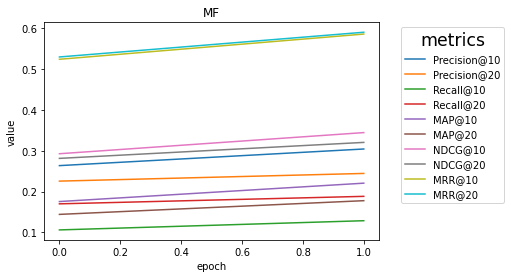

set tensorflow seed
set pytorch seed
doing Caser lr=0.001_l2_reg=1e-6_emb_size=50_seq_L=5_seq_T=3_nv=4_nh=16_dropout=0.5_neg_samples=3_batch_size=512_epochs=1_param_init=normal
2020-11-01 08:38:42.994: my pid: 20948
2020-11-01 08:38:42.995: model: model.sequential_recommender.pytorch.Caser
2020-11-01 08:38:42.997: Dataset statistics:
Name: ml-100k_ratio_u5_i5
The number of users: 943
The number of items: 1349
The number of ratings: 99287
Average actions of users: 105.29
Average actions of items: 73.60
The sparsity of the dataset: 92.195075%

The number of training: 69918
The number of validation: 0
The number of testing: 29369
2020-11-01 08:38:42.999: NeuRec:[NeuRec]:
recommender=Caser
platform=pytorch
data_dir='dataset\ml-100k_ratio_u5_i5'
file_column=UIRT
sep='\t'
gpu_id=0
gpu_mem=0.99
metric=["Precision", "Recall", "MAP", "NDCG", "MRR"]
top_k=[10,20]
test_thread=4
test_batch_size=64
seed=2020

Caser:[hyperparameters]:
lr=0.001
l2_reg=1e-6
emb_size=50
seq_L=5
seq_T=3
nv=4
nh=16
dropo

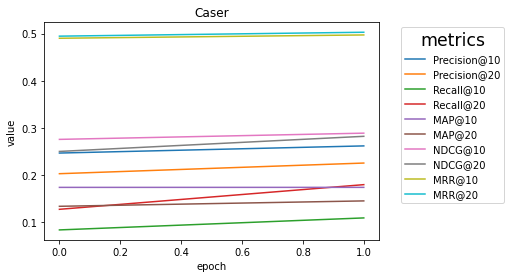

[   {   'MF': {   'MAP@10': [0.17562166, 0.2206445],
                  'MAP@20': [0.14417578, 0.17776126],
                  'MRR@10': [0.524087, 0.58585095],
                  'MRR@20': [0.52975166, 0.59031165],
                  'NDCG@10': [0.2927482, 0.34451437],
                  'NDCG@20': [0.28135666, 0.32049936],
                  'Precision@10': [0.2636268, 0.3043482],
                  'Precision@20': [0.225663, 0.24448615],
                  'Recall@10': [0.10615417, 0.12869696],
                  'Recall@20': [0.17002396, 0.1883594]}},
    {   'Caser': {   'MAP@10': [0.17385097, 0.17390497],
                     'MAP@20': [0.1337153, 0.14516118],
                     'MRR@10': [0.4901524, 0.49718723],
                     'MRR@20': [0.49461257, 0.5029165],
                     'NDCG@10': [0.27566516, 0.2888613],
                     'NDCG@20': [0.2500864, 0.2821757],
                     'Precision@10': [0.24665971, 0.26182416],
                     'Precision@20': [0.202863

In [29]:
from datetime import datetime
path = 'C:/Projects/NeuRec/results/' + datetime.now().strftime('%Y%m%d%H%M%S')
os.mkdir(path)

results = []
general = ['MF']  # , 'CDAE', 'LightGCN', 'MultVAE', 'NGCF']  ##',FISM']
sequential = ['Caser']  # , 'FPMC', 'HGN', 'TransRec']
for algo in [*general, *sequential]:
    results.append(evaluate(algo, path))

pp.pprint(results)

[{'Precision@10': [0.2636268, 0.3043482], 'Precision@20': [0.225663, 0.24448615], 'Recall@10': [0.10615417, 0.12869696], 'Recall@20': [0.17002396, 0.1883594], 'MAP@10': [0.17562166, 0.2206445], 'MAP@20': [0.14417578, 0.17776126], 'NDCG@10': [0.2927482, 0.34451437], 'NDCG@20': [0.28135666, 0.32049936], 'MRR@10': [0.524087, 0.58585095], 'MRR@20': [0.52975166, 0.59031165]}]


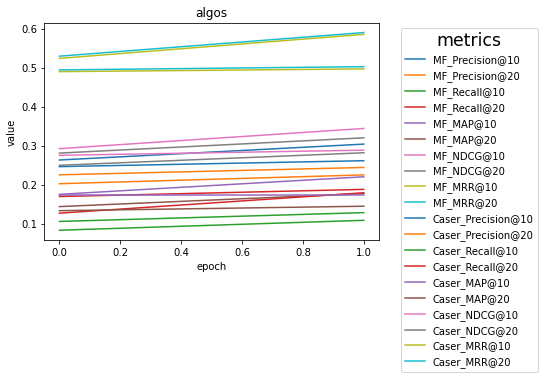

In [111]:
#print(val)
print(list(results[0].values()))

for result in results:
    for metric in metrics:
        algo = list(result)[0]
        title=algo + '_' + metric
        key, val = next(iter(result.items()))
        plt.plot(list(range(len(val[metric]))), val[metric], label=title)
    
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('algos')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='metrics', title_fontsize='xx-large')
plt.show()